In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Callable, Optional

# 🧬 Resolución del problema de las N-reinas mediante Algoritmos Genéticos (AG)

Este proyecto aborda la resolución del clásico problema de las N-reinas utilizando Algoritmos Genéticos (AG), una técnica inspirada en los procesos evolutivos de la naturaleza.

El objetivo del problema es colocar N reinas en un tablero de ajedrez de NxN de forma que ninguna pueda atacar a otra, es decir, que no compartan fila, columna ni diagonal. Aunque la solución puede encontrarse mediante enfoques clásicos como el backtracking, aquí se propone una alternativa basada en inteligencia artificial evolutiva, capaz de buscar soluciones eficientes incluso para valores grandes de N.

## 1. Parámetros iniciales:

### 1.1. Representación del individuo

En este proyecto, cada individuo de la población será representado mediante una **permutación de N números**, donde cada número indica la **fila** en la que se ubica una reina, y su posición en el vector representa la **columna** correspondiente.

Por ejemplo, el cromosoma:

(1 3 2 4)


se interpreta como:
- La reina de la **fila 1** está en la **columna 1**,
- La reina de la **fila 2** está en la **columna 3**,
- La reina de la **fila 3** está en la **columna 2**,
- La reina de la **fila 4** está en la **columna 4**.

Esta representación garantiza automáticamente que **no haya conflictos en columnas ni filas**, ya que cada número (fila) y cada posición (columna) del vector son únicos.  
Por lo tanto, la evaluación se centra exclusivamente en detectar **conflictos en diagonales**, lo que simplifica la función de aptitud.

### 1.2. Evaluación (función de aptitud / fitness)

En el problema de las N-reinas, el objetivo es colocar \( N \) reinas en un tablero de \( N x N \) de forma que ninguna de las reinas se ataque. Las reinas se atacan si están en la misma fila, columna o diagonal. La función de fitness que se presenta evalúa cuántas parejas de reinas no se atacan entre sí diagonalmente. Cuanto mayor sea el valor de fitness, mejor es la disposición de las reinas en el tablero.

La fórmula matemática para la función de fitness es la siguiente:

$$
\text{fitness}(\text{población}) = \sum_{i=1}^{n} \sum_{j=i+1}^{n} \left[ \left| \text{individuo}[i] - \text{individuo}[j] \right| == \left| i - j \right| \right]
$$


Para facilitar la programación del algoritmo, crearemos una clase para representar el cromosoma junto a la función de fitness:

In [2]:
def fitness(cromosoma: List[int]) -> int:
    """
    Calcula el valor de fitness de un cromosoma para el problema de las N-reinas.
    
    :param cromosoma: Una lista de enteros que representa la disposición de las reinas en el tablero.
    :return: Un valor entero que indica el fitness del cromosoma.
    """
    fitness = 0
    for i in range(len(cromosoma)):
        for j in range(i + 1, len(cromosoma)):
            fitness += (np.abs(cromosoma[i] - cromosoma[j]) == np.abs(i - j))
                    
    return fitness

In [3]:
class Individuo:
    def __init__(self, 
                 N_cromosoma: int, 
                 f_fitness: Callable[[List[int]], int], 
                 cromosoma: Optional[List[int]] = None) -> None:
        """
        Inicializa un individuo con un cromosoma aleatorio o proporcionado, y calcula su fitness.
        
        :param N_cromosoma: Número de reinas (tamaño del tablero).
        :param f_fitness: Función de fitness que evalúa un cromosoma.
        :param cromosoma: Una lista de enteros representando la disposición de las reinas. Si no se proporciona, se genera aleatoriamente.
        """
        self.N_cromosoma = N_cromosoma
        if cromosoma is None:
            # Genera un cromosoma aleatorio
            self.cromosoma = random.sample(range(N_cromosoma), N_cromosoma)
        else:
            self.cromosoma = cromosoma
        self.f_fitness = f_fitness
        # Calcula el fitness del individuo
        self.fitness = f_fitness(self.cromosoma)

    def mostrar_individuo(self) -> None:
        """
        Muestra el cromosoma y el fitness del individuo.
        """
        print("Cromosoma:", self.cromosoma)
        print("Fitness:", self.fitness)


Probamos la clase creada:

In [4]:
individuo = Individuo(N_cromosoma=4, f_fitness=fitness)
individuo.mostrar_individuo()

Cromosoma: [1, 0, 3, 2]
Fitness: 4


### 1.3. Representación y generación de la población:

En un algoritmo genético, la población representa el conjunto de posibles soluciones al problema que estamos tratando de resolver. Cada individuo dentro de la población es una solución candidata que será evaluada y, en función de su calidad (fitness), podrá reproducirse, mutar o ser reemplazada a lo largo de las generaciones.

En este caso, vamos a crear una **clase Población** que se encargará de representar y gestionar la población de individuos. Esta clase incluirá métodos para:

1. **Generar la población inicial**: Crearemos una población inicial de individuos de manera aleatoria, basándonos en las reglas del problema (en este caso, el problema de las N-reinas). Cada individuo representará una posible disposición de las reinas en el tablero.
   
2. **Evaluar la población**: Evaluaremos el fitness de cada individuo en la población utilizando la función de fitness definida anteriormente. Esto nos permitirá medir qué tan "buena" es cada solución en términos de su capacidad para resolver el problema de las N-reinas.

3. **Gestionar la población**: La clase también se encargará de gestionar la población a lo largo de las generaciones, permitiendo operaciones como la selección de progenitores, la reproducción (cruce) y la mutación.

Al crear esta clase, podemos abstraer la complejidad de manejar la población de manera organizada, facilitando la implementación y el mantenimiento del algoritmo genético.

### Objetivos:
- **Representar la población de individuos** de manera eficiente.
- **Gestionar las operaciones** de selección, cruce y mutación en la población a lo largo de las generaciones.
- **Evaluar el fitness** de los individuos y seleccionar a los mejores para la reproducción.

De esta manera, la clase Población servirá como el núcleo para las interacciones entre los individuos y las generaciones del algoritmo genético.


In [5]:
class Poblacion:
    def __init__(self, 
                 N_poblacion: int, 
                 N_cromosoma: int, 
                 f_fitness: Callable[[List[int]], int], 
                 individuos: Optional[List[Individuo]] = None) -> None:
        """
        Inicializa una población de individuos para el algoritmo genético.

        :param N_poblacion: Número de individuos en la población.
        :param N_cromosoma: Número de reinas (dimensión del cromosoma).
        :param f_fitness: Función de fitness que evalúa el cromosoma de cada individuo.
        :param individuos: Lista opcional de individuos. Si no se proporciona, se generará una población aleatoria.
        """
        self.N_poblacion = N_poblacion
        self.N_cromosoma = N_cromosoma
        # Inicializamos los individuos
        if individuos is None:
            self.individuos = [Individuo(N_cromosoma=N_cromosoma, f_fitness=f_fitness) 
                               for _ in range(N_poblacion)]
        else:
            self.individuos = individuos

        # Calculamos los fitness de la población
        self.fitness_poblacion = [individuo.fitness for individuo in self.individuos]
        self.fitness_medio = np.mean(self.fitness_poblacion)

    def mostrar_poblacion(self) -> None:
        """
        Muestra todos los individuos de la población con su cromosoma y su fitness.
        """
        for idx, individuo in enumerate(self.individuos):
            print(f"Individuo {idx}:")
            individuo.mostrar_individuo()
            print()


Probamos la clase creada:

In [6]:
poblacion = Poblacion(N_poblacion=5, N_cromosoma=4, f_fitness=fitness)
poblacion.mostrar_poblacion()

Individuo 0:
Cromosoma: [2, 3, 1, 0]
Fitness: 2

Individuo 1:
Cromosoma: [3, 2, 1, 0]
Fitness: 6

Individuo 2:
Cromosoma: [1, 2, 0, 3]
Fitness: 1

Individuo 3:
Cromosoma: [1, 3, 2, 0]
Fitness: 1

Individuo 4:
Cromosoma: [1, 3, 2, 0]
Fitness: 1



### 1.4. Selección de progenitores:

En los algoritmos genéticos, la selección de progenitores es un paso clave para generar nuevas soluciones a partir de la población actual. Se busca elegir a los individuos más aptos para reproducirse y generar descendencia, de manera que las mejores soluciones tengan una mayor probabilidad de ser seleccionadas.

En este caso, se utilizará el **método de la ruleta**, también conocido como **selección proporcional al ajuste** o **selección basada en fitness**. Este método simula una ruleta en la que cada individuo tiene un espacio proporcional a su valor de fitness. Cuanto menor sea el fitness de un individuo, mayor será su probabilidad de ser seleccionado como progenitor.

El proceso funciona de la siguiente manera:
1. **Calcular el fitness invertido de los individuos**: max_fitness(poblacion) - fitness(individuo).
2. **Asignar una probabilidad de selección**: Cada individuo tiene una probabilidad de ser seleccionado que es proporcional a su fitness invertido. Es decir, los individuos con un fitness menor tienen más probabilidades de ser elegidos.
3. **Seleccionar progenitores**: Se realiza una selección aleatoria, donde la probabilidad de selección de cada individuo es proporcional a su fitness invertido. Este proceso se repite hasta que se elijan los progenitores necesarios para la reproducción. Se hace una selección sin reemplazamiento.

In [7]:
def seleccionar_progenitores(poblacion: 'Poblacion', N_progenitores: int) -> List['Individuo']:
    """
    Selecciona un número de progenitores de la población utilizando el método de la ruleta,
    donde los individuos con mejor fitness (fitness más bajo) tienen mayor probabilidad de ser seleccionados.
    La selección es sin reemplazo, lo que evita que un individuo sea seleccionado más de una vez.

    :param poblacion: La población de individuos de la cual se seleccionan los progenitores.
    :param N_progenitores: El número de progenitores que se desean seleccionar.
    :return: Una lista de progenitores seleccionados.
    """
    # Calculamos las probabilidades basadas en el fitness invertido (fitness bajo = mejor)
    fitness_invertido = 1 / (1 + np.array(poblacion.fitness_poblacion))

    # Seleccionamos los progenitores sin reemplazo
    progenitores_indices = np.random.choice(len(poblacion.individuos), size=N_progenitores, replace=False, p=fitness_invertido / np.sum(fitness_invertido))
    
    progenitores = [poblacion.individuos[i] for i in progenitores_indices]

    return progenitores

In [8]:
progenitores = seleccionar_progenitores(poblacion, 2)
for idx, progenitor in enumerate(progenitores):
    print(f"Progenitor {idx}:")
    progenitor.mostrar_individuo()
    print()

Progenitor 0:
Cromosoma: [1, 3, 2, 0]
Fitness: 1

Progenitor 1:
Cromosoma: [2, 3, 1, 0]
Fitness: 2



### 1.5. Cruzamiento de los progenitores:

Una vez seleccionados los progenitores, se realiza el cruzamiento con el objetivo de combinar la información genética de dos individuos y generar nuevos cromosomas (descendientes) que hereden características de ambos padres.
Para este problema, donde los cromosomas representan permutaciones válidas (como en el caso del problema de las N-reinas), utilizamos el Cruzamiento Parcialmente Mapeado (PMX). Este método asegura que los hijos generados también sean permutaciones válidas, evitando duplicados y manteniendo la diversidad genética.
El PMX conserva bloques de genes del primer progenitor y completa el resto del cromosoma respetando el orden y la posición relativa de los genes del segundo progenitor, mediante un sistema de correspondencias.

In [9]:
def cruzar_progenitores(progenitor1: 'Individuo', progenitor2: 'Individuo') -> List[int]:
    """
    Realiza el cruzamiento parcialmente mapeado (PMX) entre dos progenitores.
    
    :param progenitor1: Primer progenitor (objeto Individuo).
    :param progenitor2: Segundo progenitor (objeto Individuo).
    :return: Cromosoma resultante del cruzamiento (lista de enteros).
    """
    p1 = progenitor1.cromosoma
    p2 = progenitor2.cromosoma
    N = len(p1)

    # Seleccionamos dos puntos de corte aleatorios
    punto1, punto2 = sorted(random.sample(range(N), 2))

    hijo = [None] * N

    # Copiamos el segmento entre los puntos del primer progenitor
    hijo[punto1:punto2] = p1[punto1:punto2]

    # Mapeo entre genes del segmento
    for i in range(punto1, punto2):
        if p2[i] not in hijo:
            val = p2[i]
            pos = i
            while True:
                val_mapeado = p1[pos]
                if val_mapeado not in hijo:
                    pos = p2.index(val_mapeado)
                else:
                    break
            hijo[pos] = val

    # Rellenamos el resto con genes del segundo progenitor
    for i in range(N):
        if hijo[i] is None:
            hijo[i] = p2[i]

    return Individuo(N_cromosoma=N, 
                     f_fitness=progenitor1.f_fitness, 
                     cromosoma=hijo)

In [10]:
hijo = cruzar_progenitores(progenitor1=progenitores[0], 
                           progenitor2=progenitores[1])
hijo.mostrar_individuo()

Cromosoma: [2, 3, 1, 0]
Fitness: 2


### 1.6. Mutación de los descendientes:

Después del cruzamiento, se aplica una operación de mutación con el objetivo de introducir variación genética y evitar que la población se estanque en soluciones subóptimas.

En este caso, utilizaremos la **Mutación por sacudida**, una técnica adecuada para problemas de permutación como las N-reinas.

Esta mutación consiste en seleccionar dos posiciones aleatorias dentro del cromosoma y reordenar aleatoriamente (hacer un *shuffle*) todos los genes comprendidos entre esas dos posiciones.  
Este enfoque permite una modificación más significativa del cromosoma, explorando nuevas configuraciones sin violar la restricción de que todos los genes deben ser únicos.

Esta estrategia es efectiva para mantener la diversidad y fomentar la exploración del espacio de soluciones.


In [11]:
def mutar_individuo(individuo: 'Individuo') -> List[int]:
    """
    Aplica la mutación por sacudida a un cromosoma.
    Se selecciona un segmento aleatorio dentro del cromosoma
    y se reordenan aleatoriamente los genes dentro de ese segmento.

    :param cromosoma: Cromosoma original (permutación de enteros).
    :return: Cromosoma mutado.
    """
    cromosoma = individuo.cromosoma
    mutado = cromosoma.copy()
    N_cromosoma = len(cromosoma)

    # Seleccionar dos índices aleatorios distintos
    i, j = sorted(random.sample(range(N_cromosoma), 2))

    # Mezclar aleatoriamente los elementos entre i y j (inclusive)
    segmento = mutado[i:j+1]
    random.shuffle(segmento)
    mutado[i:j+1] = segmento

    return Individuo(N_cromosoma=N_cromosoma, 
                     f_fitness=individuo.f_fitness, 
                     cromosoma=mutado)

In [12]:
mutado = mutar_individuo(individuo)
print("Individuo sin mutar: ")
individuo.mostrar_individuo()
print()
print("Individuo mutado: ")
mutado.mostrar_individuo()

Individuo sin mutar: 
Cromosoma: [1, 0, 3, 2]
Fitness: 4

Individuo mutado: 
Cromosoma: [1, 2, 0, 3]
Fitness: 1


### 1.7. Selección de Supervivientes:

Una vez que se han generado los descendientes a través del cruzamiento y la mutación, se procede a la **selección de supervivientes** para conformar la siguiente generación.

En esta etapa, se combinan los individuos de la generación actual con los nuevos descendientes, y se seleccionan los **mejores N individuos** en función de su valor de fitness.

Dado que el objetivo del problema de las N-reinas es minimizar el número de conflictos (es decir, minimizar el valor del fitness), se eligen los **N individuos con menor fitness** para asegurar que la población evolucione hacia soluciones más óptimas en cada generación.

In [13]:
def seleccionar_supervivientes(poblacion: Poblacion, descendientes: List[Individuo]) -> Poblacion:
    """
    Selecciona a los mejores individuos de la población actual y los descendientes.
    Elimina a los peores individuos y mantiene los mejores N de acuerdo al fitness.

    :param poblacion: Objeto de la clase Poblacion que representa la población actual.
    :param descendientes: Lista de individuos generados en la última generación (descendientes).
    :return: Nueva población formada por los mejores individuos (supervivientes).
    """
    # Agregamos los descendientes a la población actual
    individuos = poblacion.individuos + descendientes
    
    # Obtenemos la información básica de la población
    N_cromosoma = individuos[0].N_cromosoma  # Número de genes en cada cromosoma
    N_poblacion = poblacion.N_poblacion  # Tamaño original de la población
    f_fitness = individuos[0].f_fitness  # Función de fitness utilizada
    N_poblacion_nueva = len(individuos)  # Nueva población que incluye descendientes
    
    # Creamos una nueva población con los individuos actuales + descendientes
    poblacion_nueva = Poblacion(
        N_poblacion=N_poblacion_nueva,
        N_cromosoma=N_cromosoma,
        f_fitness=f_fitness,
        individuos=individuos
    )
    
    # Obtenemos los fitness de todos los individuos
    fitness_poblacion = poblacion_nueva.fitness_poblacion
    
    # Ordenamos los índices de los individuos de la población según el fitness (menor a mayor)
    best_fit_idx = np.argsort(fitness_poblacion)
    
    # Seleccionamos los mejores N individuos con menor fitness
    individuos_supervivientes = [individuos[i] for i in best_fit_idx[:N_poblacion]]
    
    # Creamos una nueva población con los mejores N individuos
    poblacion_superviviente = Poblacion(
        N_poblacion=N_poblacion,
        N_cromosoma=N_cromosoma,
        f_fitness=f_fitness,
        individuos=individuos_supervivientes
    )
    
    return poblacion_superviviente

Probamos la función creada:

In [14]:
# Inicializamos la población con 5 individuos, cada uno con un cromosoma de longitud 4.
poblacion = Poblacion(N_poblacion=5, 
                      N_cromosoma=4, 
                      f_fitness=fitness)

# Seleccionamos 2 progenitores basados en su fitness.
progenitores = seleccionar_progenitores(poblacion=poblacion, N_progenitores=2)

# Cruzamos los progenitores para crear los hijos.
hijo1 = cruzar_progenitores(progenitor1=progenitores[0],
                             progenitor2=progenitores[1])
hijo2 = cruzar_progenitores(progenitor1=progenitores[1],
                             progenitor2=progenitores[0])

# Mutamos el primer hijo intercambiando aleatoriamente dos posiciones en su cromosoma.
mutado = mutar_individuo(individuo=hijo1)

# Seleccionamos los mejores individuos para la siguiente generación.
poblacion_superviviente = seleccionar_supervivientes(poblacion, [mutado, hijo1, hijo2])

# Mostramos la nueva población de supervivientes.
poblacion_superviviente.mostrar_poblacion()


Individuo 0:
Cromosoma: [0, 2, 3, 1]
Fitness: 1

Individuo 1:
Cromosoma: [3, 1, 0, 2]
Fitness: 1

Individuo 2:
Cromosoma: [0, 2, 3, 1]
Fitness: 1

Individuo 3:
Cromosoma: [3, 1, 0, 2]
Fitness: 1

Individuo 4:
Cromosoma: [3, 2, 0, 1]
Fitness: 2



### 1.8. Implementación del algoritmo genético:

Crearemos una función que implemente el algoritmo genético:

In [15]:
def AG(N_poblacion: int,
       N_cromosoma: int,
       f_fitness: Callable[[List[int]], int],
       prob_cruz: float = 0.05,
       prob_mut: float = 0.01,
       num_iteraciones: int = 200) -> Tuple['Individuo', int, List[int], List[int]]:
    """
    Ejecuta un algoritmo genético para resolver el problema de las N-reinas.

    :param N_poblacion: Número de individuos en la población.
    :param N_cromosoma: Tamaño del cromosoma (N del problema).
    :param f_fitness: Función de evaluación de fitness.
    :param prob_cruz: Probabilidad de realizar cruzamiento.
    :param prob_mut: Probabilidad de realizar mutación.
    :param num_iteraciones: Número de generaciones a ejecutar.
    :return: Mejor individuo, su fitness, la evolución del fitness por generación, y 
        la evolución del fitness medio por generación.
    """
    poblacion = Poblacion(N_poblacion=N_poblacion,
                          N_cromosoma=N_cromosoma,
                          f_fitness=f_fitness)

    mejor_fitness_generacion: List[int] = []
    fitness_medio_generacion: List[float] = []

    for _ in range(num_iteraciones):
        mejor_fitness_generacion.append(np.min(poblacion.fitness_poblacion))
        fitness_medio_generacion.append(poblacion.fitness_medio)
        descendientes: List[Individuo] = []

        progenitores = seleccionar_progenitores(poblacion=poblacion, N_progenitores=2)
        progenitor1, progenitor2 = progenitores[0], progenitores[1]

        if np.random.rand() <= prob_cruz:
            hijo = cruzar_progenitores(progenitor1=progenitor1, 
                                       progenitor2=progenitor2)
            descendientes.append(hijo)

            if np.random.rand() <= prob_mut:
                mutado = mutar_individuo(hijo)
                descendientes.append(mutado)

        poblacion = seleccionar_supervivientes(poblacion=poblacion, descendientes=descendientes)

    fitness_poblacion = poblacion.fitness_poblacion
    best_idx = np.argmin(fitness_poblacion)
    mejor_solucion = poblacion.individuos[best_idx]
    mejor_fitness = fitness_poblacion[best_idx]

    return mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion

Crearemos una función para visualizar la evolución del mejor fitness y el fitness medio:

In [16]:
def mostrar_historial_fitness(mejor_fitness: List[int], fitness_medio: List[float]) -> None:
    """
    Muestra la evolución del mejor fitness y el fitness medio a lo largo de las generaciones.

    :param mejor_fitness: Lista con el mejor fitness por generación.
    :param fitness_medio: Lista con el fitness medio por generación.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(mejor_fitness, label="Mejor Fitness", color="green")
    plt.plot(fitness_medio, label="Fitness Medio", color="blue")
    plt.xlabel("Generaciones")
    plt.ylabel("Fitness")
    plt.title("Evolución del Fitness")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Probamos las funciones creadas:

Cromosoma: [5, 8, 6, 3, 0, 2, 9, 1, 9, 7]
Fitness: 1


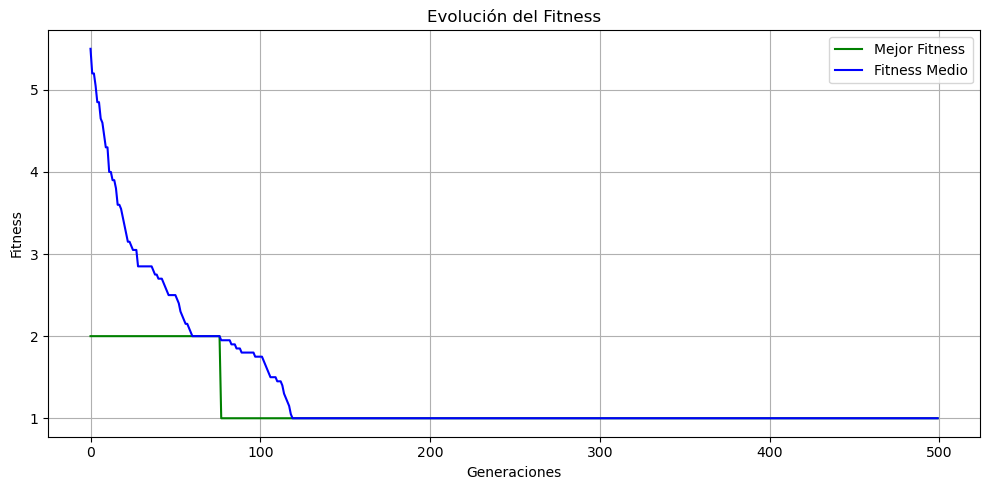

In [17]:
# Ejecutamos el algoritmo genético
mejor_solucion, mejor_fitness, mejor_fitness_generacion, fitness_medio_generacion = AG(
    N_poblacion=20,
    N_cromosoma=10,
    f_fitness=fitness,
    prob_cruz=0.9,
    prob_mut=0.3,
    num_iteraciones=500
)

# Mostramos resultados
mejor_solucion.mostrar_individuo()
mostrar_historial_fitness(mejor_fitness_generacion, fitness_medio_generacion)